In [9]:
!pip install patchify

In [2]:
import tifffile
import numpy as np
import cv2
from patchify import patchify
import matplotlib.pyplot as plt

In [3]:
tif_path = "../jupyter_data/all/enface/Giantin_c1/20181001-Giantin-594-GnT4B-AcGFP1-Noc-01/20181001-Giantin-594-GnT4B-AcGFP1-Noc-01.tif"

In [4]:
image = tifffile.imread(tif_path)

In [5]:
image.shape

(2, 864, 864)

# Padding image

In [6]:
def get_img_pad(img):
    patchify_step = 206
    patch_size = 256
    h, w = img.shape
    max_side = max(h, w)
    target_side = round((max_side - patch_size) / patchify_step) * patchify_step + patch_size
    diff_h = target_side - h
    diff_w = target_side - w
    if diff_h % 2 != 0:
        h_pad = (round(diff_h / 2) + 1, round(diff_h / 2) - 1)
    else:
        h_pad = round(diff_h / 2)
    if diff_w % 2 != 0:
        w_pad = (round(diff_w / 2) + 1, round(diff_w / 2) - 1)
    else:
        w_pad = round(diff_w / 2)
    print(h_pad, w_pad)
    img_pad = np.pad(img, (h_pad, w_pad), "constant", constant_values=0)
    return target_side, img_pad

### Test get_img_pad() on cat image

In [7]:
img = cv2.imread("/content/drive/MyDrive/ntu-FYP/Golgi_en-face_analysis/data/tif/1.jpg")

In [8]:
height = 812
img = cv2.resize(img, (height, height))
c1 = img[:, :, 0]
c1.shape

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(c1)

In [ ]:
pad_size, img_pad = get_img_pad(c1)
print(pad_size)

In [ ]:
patches = patchify(img_pad, [256, 256], step=206)
print(patches.shape)
plt.figure(figsize=(10, 10))
n = patches.shape[0]
m = patches.shape[1]
for i in range(n):
    for j in range(m):
        plt.subplot(n, m, i * n + j + 1)
        plt.imshow(patches[i][j])
        plt.axvline(x=50, ls="-", c="red")
        plt.axvline(x=206, ls="-", c="orange")
        plt.axhline(y=50, ls="-", c="red")
        plt.axhline(y=206, ls="-", c="orange")

In [ ]:
all(img_pad[pad_size - 100][pad_size - 100:] == patches[-1][-1][156][156:])

In [ ]:
patches[-1][-1][156][156:]

### Test on real golgi image

In [ ]:
tif_path = "/content/drive/MyDrive/ntu-FYP/Golgi_en-face_analysis/data/tif/all/Giantin_c1/20181001-HeLa-Giantin-647-mCherryG84-ACBD3-GFP-Noc-01/20181001-HeLa-Giantin-647-mCherryG84-ACBD3-GFP-Noc-01.tif"
roi_path = "/content/drive/MyDrive/ntu-FYP/Golgi_en-face_analysis/data/tif/all/Giantin_c1/20181001-HeLa-Giantin-647-mCherryG84-ACBD3-GFP-Noc-01/RoiSet.zip"

In [ ]:
folder_path = "/content/drive/MyDrive/ntu-FYP/Golgi_en-face_analysis/data/tif/all/SIDE_VIEW/20191114-Giantin-594-Cab45-myc-488-Noc-03/"
tif_path = folder_path + "20191114-Giantin-594-Cab45-myc-488-Noc-03_BGST.tif"
roi_path = folder_path + "RoiSet.zip"

In [ ]:
golgi_img = tifffile.imread(tif_path)

In [ ]:
golgi_img.shape

Select giantin channel

In [ ]:
c_giantin = 0
giantin_img = golgi_img[c_giantin]
print(giantin_img.shape)

In [ ]:
plt.imshow(giantin_img)

In [ ]:
pad_size, pad_golgi = get_img_pad(giantin_img)
print(pad_size)

In [ ]:
patches = patchify(pad_golgi, [256, 256], step=206)

In [ ]:
all(pad_golgi[pad_size - 100][pad_size - 100:] == patches[-1][-1][156][156:])

# Process ROI

### ROI PROCESS

In [ ]:
!pip install read_roi

In [9]:
from read_roi import read_roi_zip
from tensorflow.keras.utils import Progbar

In [10]:
def roi_to_mask(roi_path, img):
    roi = read_roi_zip(roi_path)
    ret_mask = np.zeros_like(img, dtype=np.uint8)
    a = Progbar(len(roi.values()))
    for i, v in enumerate(roi.values()):
        if v['type'] == 'rectangle':
            roi_x, roi_y = v['left'], v['top']
            roi_width, roi_height = v['width'], v['height']
            roi_rect = img[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]
            mask, flag = purify_mask(roi_rect)
            if flag:
                ret_mask[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width] = mask
        else:
            print("No.{} roi type is not rectangle".format(i))
        a.update(i + 1)
    return ret_mask

In [26]:
def purify_mask(img):
    sub = 0
    h, w = img.shape
    task_img = np.copy(img)
    while True:
        if sub > 0:
            for i in range(h):
                for j in range(w):
                    if task_img[i][j] > sub:
                        task_img[i][j] = task_img[i][j] - sub
                    else:
                        task_img[i][j] = 0

        mask = task_img / (task_img + 1) * 255
        mask = mask.astype(np.uint8)
        _, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        num_contours = len(contours)
        accept_contours = []
        for i, contour in enumerate(contours):
            if cv2.contourArea(contour) <= 60:
                # clear the edge contours
                cv2.drawContours(mask, contours, i, 0, -1)
                num_contours -= 1
                continue
            c_x = contour[:, :, 0].reshape(-1, )
            c_y = contour[:, :, 1].reshape(-1, )
            if h - 1 in c_x or w - 1 in c_y or 0 in c_x or 0 in c_y:
                # clear the edge contours
                cv2.drawContours(mask, contours, i, 0, -1)
                num_contours -= 1
                continue
            accept_contours.append(contour)

        if num_contours == 1:
            (x_r, y_r), radius = cv2.minEnclosingCircle(accept_contours[0])
            # Fill the center hole
            cv2.drawContours(mask, accept_contours, 0, 1, -1)
            # how contours like a circle
            area = len(np.where(mask > 0)[0])
            circle_area = (radius + 0.5) ** 2 * np.pi
            f = area / circle_area
            if f < 0.5:
                return mask, False
            else:
                return mask, True
        else:
            sub = np.where(task_img > 0, task_img, np.inf).min()

### Test for roi_zip

In [ ]:
roi = read_roi_zip(roi_path)

In [ ]:
# Show all roi rectangle region
roi_rect_list = []
for i, v in enumerate(roi.values()):
    if v['type'] == 'rectangle':
        roi_x, roi_y = v['left'], v['top']
        roi_width, roi_height = v['width'], v['height']
        print(i, roi_x, roi_y, roi_width, roi_height)
        roi_rect = giantin_img[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]
        roi_rect_show = roi_rect / (roi_rect + 1) * 255
        roi_rect_show = roi_rect_show.astype(np.uint8)
        _, roi_rect_show = cv2.threshold(roi_rect_show, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.imshow(roi_rect_show)
        plt.show()
        roi_rect_list.append(roi_rect)
    else:
        print("roi type is not rectangle")

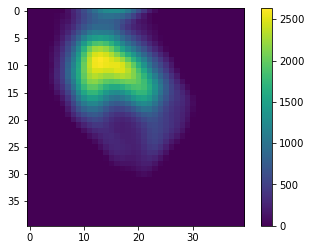

In [31]:
plt.imshow(roi_rect_list[11])
plt.colorbar()

In [32]:
from matplotlib.patches import Ellipse


def purify_mask_withPlot(img, show_flag=True):
    row, column = 1, 4
    sub = 0
    h, w = img.shape
    task_img = np.copy(img)
    if show_flag:
        mask = task_img / (task_img + 1) * 255
        mask = mask.astype(np.uint8)
        _, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.figure(figsize=(10, 10))
        plt.subplot(row, column, 1)
        plt.imshow(mask)
    while True:
        if sub > 0:
            for i in range(h):
                for j in range(w):
                    if task_img[i][j] > sub:
                        task_img[i][j] = task_img[i][j] - sub
                    else:
                        task_img[i][j] = 0

        mask = task_img / (task_img + 1) * 255
        mask = mask.astype(np.uint8)
        _, mask = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        num_contours = len(contours)
        accept_contours = []
        for i, contour in enumerate(contours):
            if cv2.contourArea(contour) <= 100:
                # clear the edge contours
                cv2.drawContours(mask, contours, i, 0, -1)
                num_contours -= 1
                continue
            c_x = contour[:, :, 0].reshape(-1, )
            c_y = contour[:, :, 1].reshape(-1, )
            if h - 1 in c_x or w - 1 in c_y or 0 in c_x or 0 in c_y:
                # clear the edge contours
                cv2.drawContours(mask, contours, i, 0, -1)
                num_contours -= 1
                continue
            accept_contours.append(contour)
        if num_contours == 0:
            return mask, -1
        elif num_contours == 1:
            if show_flag:
                plt.subplot(row, column, 2)
                plt.imshow(mask)

            # Fill the center hole
            cv2.drawContours(mask, accept_contours, 0, 1, -1)

            # rect
            rect = cv2.minAreaRect(accept_contours[0])
            f1 = min(rect[1]) / max(rect[1])
            # circle
            (r_x, r_y), radius = cv2.minEnclosingCircle(accept_contours[0])
            # ellipse
            ellipse = cv2.fitEllipse(accept_contours[0])

            pixel_counts = len(np.where(mask > 0)[0])
            ellpise_area = np.pi * ellipse[1][0] / 2 * ellipse[1][1] / 2
            circle_area = (radius) ** 2 * np.pi

            f2 = pixel_counts / circle_area
            f3 = ellpise_area / circle_area
            print("f1:{}, f2:{}, f3:{}".format(f1, f2, f3))

            if show_flag:
                ax3 = plt.subplot(row, column, 3)
                plt_circle = plt.Circle(xy=(r_x, r_y), radius=radius, fc='green', alpha=0.5)
                plt_ellpise = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2],
                                      fc="red", alpha=0.5)
                ax3.add_artist(plt_circle)
                ax3.add_artist(plt_ellpise)
                plt.imshow(mask)

                ax4 = plt.subplot(row, column, 4)
                box = cv2.boxPoints(rect)
                plt_box = plt.Rectangle((box[1]), rect[1][0], rect[1][1], rect[2], alpha=0.5)
                ax4.add_artist(plt_box)
                plt.imshow(mask)
            if f1 < 0.6:
                # side view
                return mask, -1
            if f2 > 0.5 or f3 > 0.5:
                # accpet en face
                return mask, 1
            else:
                # reject en face
                return mask, 0
        else:
            sub = np.where(task_img > 0, task_img, np.inf).min()


### Test for enface and sideview

In [11]:
import os

folder_path = "../jupyter_data/all/enface_sideview/Giantin_c2/20200330-GM130-647-Giantin-594-RUSH-Lamp1-05mBiotin-Noc-02"
file_list = os.listdir(folder_path)
if len(file_list) != 2:
    print("Number of files in folder is not 2.")

In [12]:
if file_list[0].endswith("tif"):
    tif_path = os.path.join(folder_path, file_list[0])
    roi_path = os.path.join(folder_path, file_list[1])
else:
    tif_path = os.path.join(folder_path, file_list[1])
    roi_path = os.path.join(folder_path, file_list[0])

In [13]:
print(roi_path)
print(tif_path)

../jupyter_data/all/enface_sideview/Giantin_c2/20200330-GM130-647-Giantin-594-RUSH-Lamp1-05mBiotin-Noc-02\RoiSet.zip
../jupyter_data/all/enface_sideview/Giantin_c2/20200330-GM130-647-Giantin-594-RUSH-Lamp1-05mBiotin-Noc-02\20200330-GM130-647-Giantin-594-RUSH-Lamp1-05mBiotin-Noc-02_BGST.tif


In [14]:
golgi_img = tifffile.imread(tif_path)
c_giantin = 0
giantin_img = golgi_img[c_giantin]
print(giantin_img.shape)
roi = read_roi_zip(roi_path)

(1016, 1016)


21
0 85 339 40 40


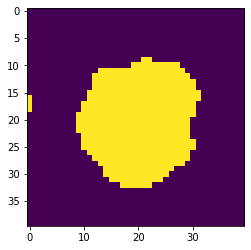

1 144 558 40 40


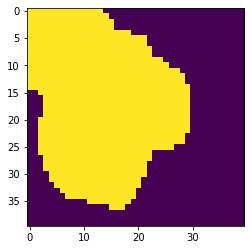

2 246 632 40 40


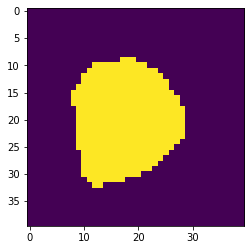

3 284 659 40 40


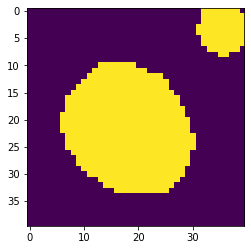

4 362 624 40 40


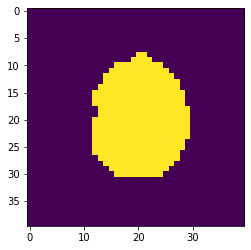

5 349 562 40 40


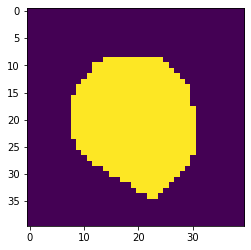

6 299 460 40 40


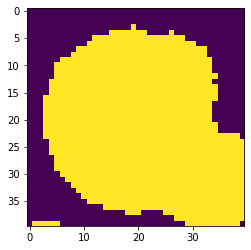

7 433 740 40 40


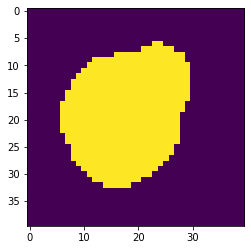

8 520 819 40 40


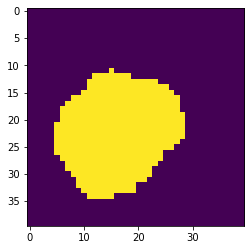

9 568 725 40 40


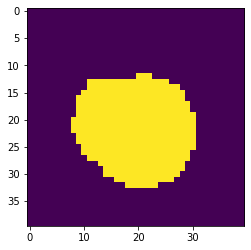

10 596 766 40 40


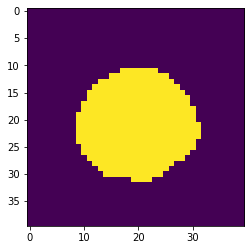

11 429 210 40 40


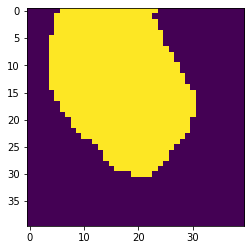

12 551 603 40 40


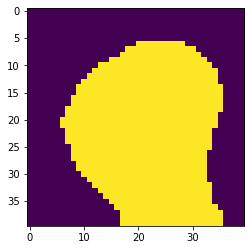

13 866 623 40 40


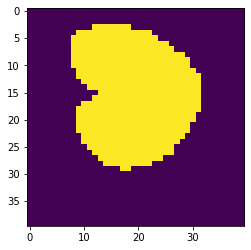

14 780 732 40 40


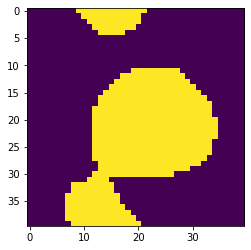

15 526 307 40 40


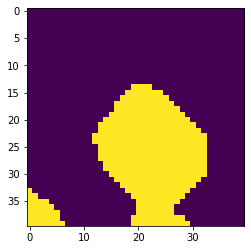

16 410 517 40 40


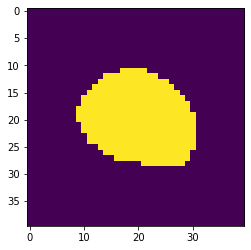

17 483 593 40 40


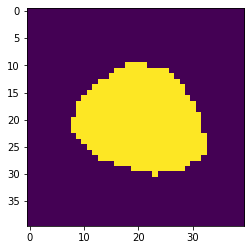

18 407 460 40 40


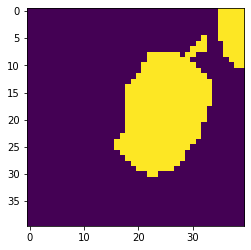

19 438 348 40 40


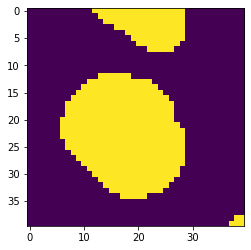

20 607 480 40 40


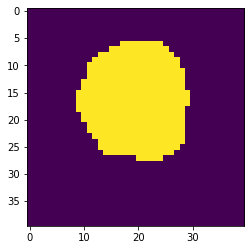

In [15]:
# Show all roi rectangle region
roi_rect_list = []
print(len(roi.values()))
for i, v in enumerate(roi.values()):
    if v['type'] == 'rectangle':
        roi_x, roi_y = v['left'], v['top']
        roi_width, roi_height = v['width'], v['height']
        print(i, roi_x, roi_y, roi_width, roi_height)
        roi_rect = giantin_img[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]
        roi_rect_show = roi_rect / (roi_rect + 1) * 255
        roi_rect_show = roi_rect_show.astype(np.uint8)
        _, roi_rect_show = cv2.threshold(roi_rect_show, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.imshow(roi_rect_show)
        plt.show()
        roi_rect_list.append(roi_rect)
    else:
        print("roi type is not rectangle")

0
f1:0.9198113042300124, f2:0.8774054784267213, f3:0.8243408469990582


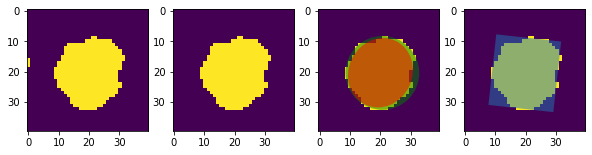

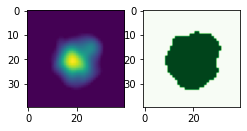

1


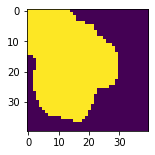

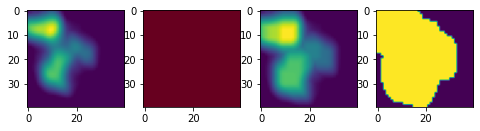

2
f1:0.9189190065370105, f2:0.807043511263132, f3:0.7674408622222969


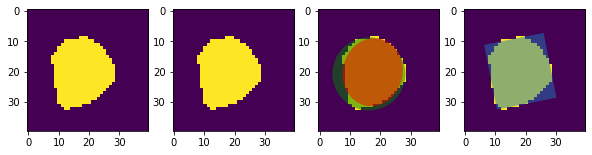

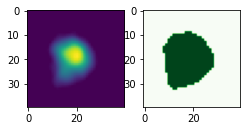

3
f1:0.885714316541695, f2:0.8563123260269816, f3:0.799198148427449


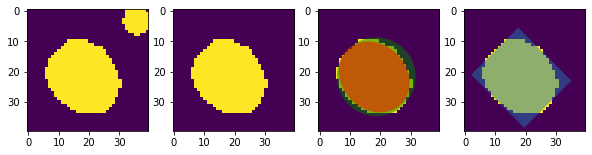

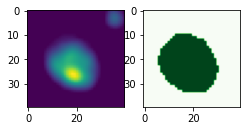

4
f1:0.7727272727272727, f2:0.7932053164880943, f3:0.7311774299391304


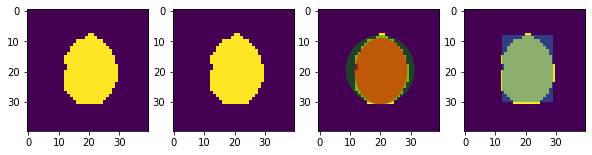

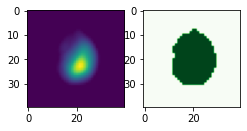

5
f1:0.885714316541695, f2:0.8168204090218832, f3:0.7678215871317178


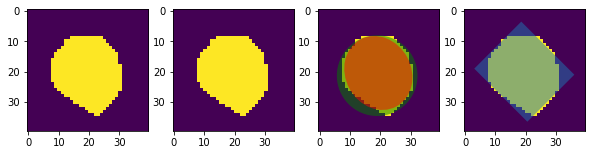

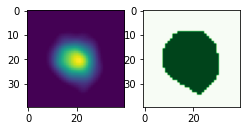

6


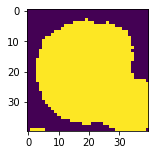

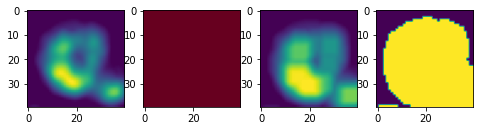

7
f1:0.8846153846153846, f2:0.7715350738475624, f3:0.7319172355561107


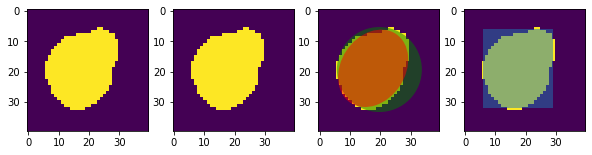

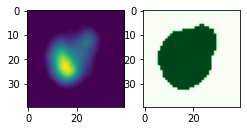

8
f1:0.8235293744304721, f2:0.8457270390116068, f3:0.797229946067283


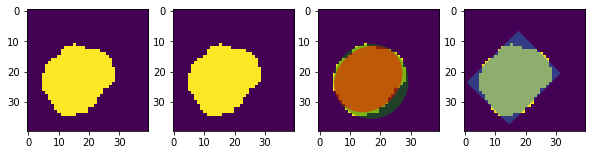

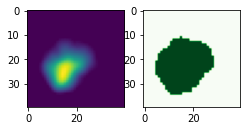

9
f1:0.9090909090909091, f2:0.8642525569506925, f3:0.8025771125736451


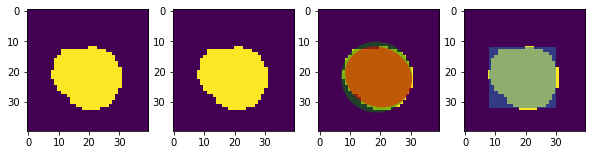

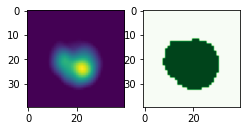

10
f1:1.0, f2:0.9224492952198673, f3:0.8543949413756114


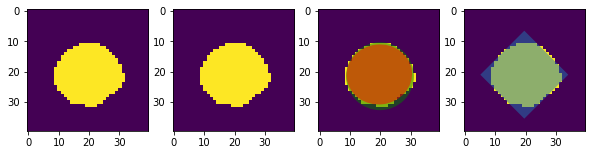

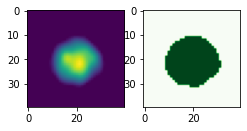

11


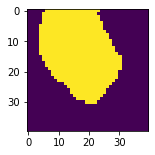

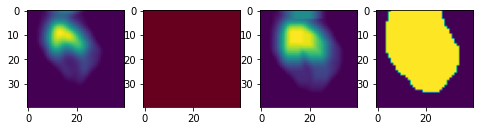

12


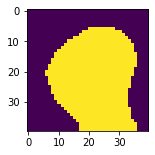

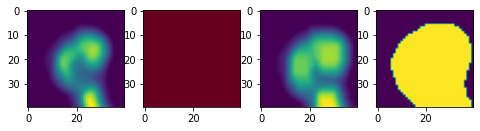

13
f1:0.8846153846153846, f2:0.8011775771356584, f3:0.7800517623074036


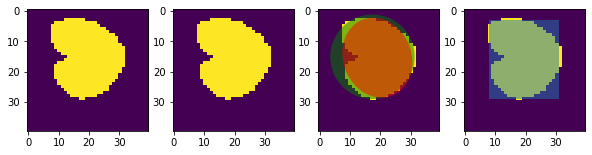

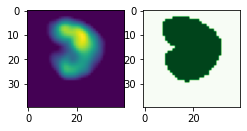

14


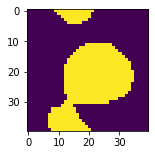

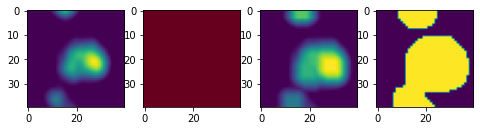

15


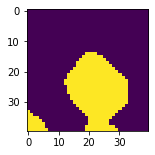

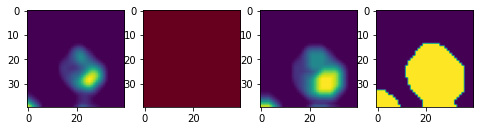

16
f1:0.8095238095238095, f2:0.7847170591221376, f3:0.7255638624580399


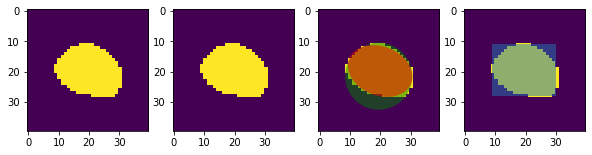

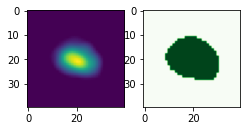

17
f1:0.8750001053671319, f2:0.7642795212472602, f3:0.7208372275169469


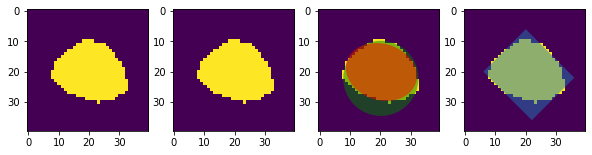

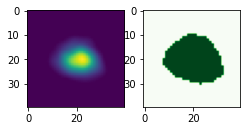

18
f1:0.5777778137985488, f2:0.5145567723415709, f3:0.49346933118332026


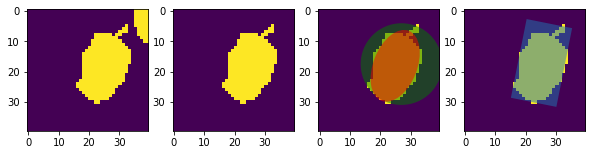

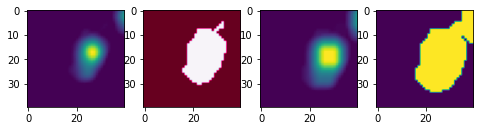

19
f1:0.8181818404743695, f2:0.8773843087223896, f3:0.8195635086216833


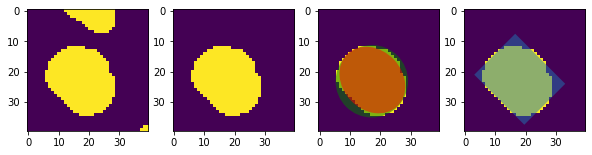

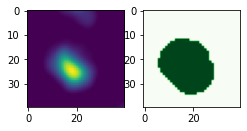

20
f1:0.9523809523809523, f2:0.9152034686491336, f3:0.8479762933020761


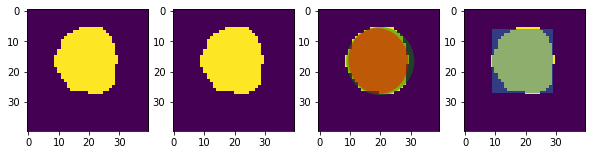

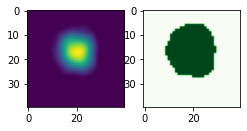

In [33]:
for i, k in enumerate(roi_rect_list):
    print(i)
    row, col = 1, 4
    mask, flag = purify_mask_withPlot(k, show_flag=True)

    plt.figure(figsize=(8, 8))
    plt.subplot(row, col, 1)
    plt.imshow(k)
    plt.subplot(row, col, 2)
    if flag == 1:
        plt.imshow(mask, cmap="Greens")
    elif flag == 0:
        plt.imshow(mask, cmap="Oranges")
    elif flag == -1:
        plt.imshow(mask, cmap="PuRd_r")
        plt.subplot(row, col, 3)
        kernel = np.ones((2, 2), np.uint8)
        opening = cv2.morphologyEx(k, cv2.MORPH_DILATE, kernel, iterations=3)
        plt.imshow(opening)

        plt.subplot(row, col, 4)
        opening = opening / (opening + 1) * 255
        opening = opening.astype(np.uint8)
        _, opening = cv2.threshold(opening, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        plt.imshow(opening)

    plt.show()

### Test cv2.contours on one roi

In [ ]:
test_cv2_contours_tif_path = "/content/drive/MyDrive/ntu-FYP/Golgi_en-face_analysis/data/test_function_data/test_edge_pixel.tif"

In [ ]:
test_cv2_contours_tif = tifffile.imread(test_cv2_contours_tif_path)

In [ ]:
sub = 20

In [ ]:
for i in range(test_cv2_contours_tif.shape[0]):
    for j in range(test_cv2_contours_tif.shape[1]):
        if test_cv2_contours_tif[i][j] < sub:
            test_cv2_contours_tif[i][j] = 0
        else:
            test_cv2_contours_tif[i][j] = test_cv2_contours_tif[i][j] - sub

In [ ]:
show_test_cv2_contours_tif = test_cv2_contours_tif / (test_cv2_contours_tif + 1) * 255
show_test_cv2_contours_tif = show_test_cv2_contours_tif.astype(np.uint8)
_, show_test_cv2_contours_tif = cv2.threshold(show_test_cv2_contours_tif, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [ ]:
plt.imshow(show_test_cv2_contours_tif)
plt.colorbar()

### Test for whole roi mask

In [ ]:
whole_mask = roi_to_mask(roi_path, giantin_img)

In [ ]:
whole_mask.shape

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(whole_mask)

In [ ]:
pad_size, img_pad = get_img_pad(whole_mask)
print(pad_size)

patches = patchify(img_pad, [256, 256], step=206)
print(patches.shape)
plt.figure(figsize=(12, 12))
n = patches.shape[0]
m = patches.shape[1]
for i in range(n):
    for j in range(m):
        plt.subplot(n, m, i * n + j + 1)
        plt.imshow(patches[i][j])
        plt.axvline(x=50, ls="-", c="red")
        plt.axvline(x=206, ls="-", c="orange")
        plt.axhline(y=50, ls="-", c="red")
        plt.axhline(y=206, ls="-", c="orange")

### Test for clear contours in the edge

In [ ]:
def clear_mask_patches(patches_in):
    cleared_patches = np.copy(patches_in)
    n = patches.shape[0]
    m = patches.shape[1]
    h, w = patches.shape[2:]
    for i in range(n):
        for j in range(m):
            if cleared_patches[i][j].sum() == 0:
                continue
            contours, _ = cv2.findContours(cleared_patches[i][j], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            for n, contour in enumerate(contours):
                c_x = contour[:, :, 0].reshape(-1, )
                c_y = contour[:, :, 1].reshape(-1, )
                if h - 1 in c_x or w - 1 in c_y or 0 in c_x or 0 in c_y:
                    # clear the edge contours
                    cv2.drawContours(cleared_patches[i][j], contours, n, 0, -1)
                    continue
    return cleared_patches

In [ ]:
cleared_patches = clear_mask_patches(patches)

In [ ]:
h, w = 256, 256
n = patches.shape[0]
m = patches.shape[1]
for i in range(n):
    for j in range(m):
        patch = cleared_patches[i][j]
        if patch.sum() == 0:
            continue
        contours, _ = cv2.findContours(patch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for n, contour in enumerate(contours):
            c_x = contour[:, :, 0].reshape(-1, )
            c_y = contour[:, :, 1].reshape(-1, )
            if h - 1 in c_x or w - 1 in c_y or 0 in c_x or 0 in c_y:
                # clear the edge contours
                cv2.drawContours(patch, contours, n, 0, -1)
                continue

In [ ]:
plt.figure(figsize=(12, 12))
n = patches.shape[0]
m = patches.shape[1]
for i in range(n):
    for j in range(m):
        plt.subplot(n, m, i * n + j + 1)
        plt.imshow(cleared_patches[i][j])
        plt.axvline(x=50, ls="-", c="red")
        plt.axvline(x=206, ls="-", c="orange")
        plt.axhline(y=50, ls="-", c="red")
        plt.axhline(y=206, ls="-", c="orange")

In [ ]:
plt.imshow(cleared_patches[0][2])